# PHRAIME (Klebsiella)

An AI-based Phage-Host interaction predictor framework with receptors and receptor-binding proteins at its core. This particular PHRAIME is for *Klebsiella pneumoniae* related phages.

This notebook follows after having ran the PhageHostPredict_processing steps implemented in the accompanying Python script.

The predictive framework works as follows:

1. [Transform the locus into an embedding using Word2Vec](#locusembed)
3. [Transform the RBP sequence into an embedding](#rbpembed) using UniRep, ProtTransBert, SeqVec, ...
3. [Exploring the interactions space](#interactions) for insight and further improvement
4. [Concatenate and train an RF model](#models) via cross-validation

## 0 - Libraries and directories

In [83]:
import os
import math
import umap
import random
import subprocess
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import cm
from tqdm.notebook import tqdm
from Bio import SeqIO
from Bio.Blast import NCBIWWW, NCBIXML
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.metrics import make_scorer, f1_score
from sklearn.ensemble import RandomForestClassifier
from Bio.Blast.Applications import NcbiblastpCommandline
from sklearn.model_selection import GridSearchCV, KFold, StratifiedKFold, cross_val_score
#from bio_embeddings.embed import Word2VecEmbedder, ProtTransBertBFDEmbedder, SeqVecEmbedder
%matplotlib inline

In [2]:
# set project directory (to locate Kaptive), data directory and results directory
project_dir = '/Users/dimi/Documents/GitHub_Local/PhageHostLearning'
klebsiella_dir = '/Users/dimi/GoogleDrive/PhD/4_PHAGEHOST_LEARNING/42_DATA/Klebsiella_RBP_data'
results_dir = '/Users/dimi/GoogleDrive/PhD/4_PHAGEHOST_LEARNING/43_RESULTS'
cdpath = '/Users/dimi/cd-hit-v4.8.1-2019-0228'

## 1 - Transform locus into embeddings<a name="locusembed"></a>

In [13]:
def locus_embeddings(interactions, data_dir, results_dir):
    """
    This functions computes ProtTransBertBFD embeddings for bacterial genomic loci. It uses the bio-embeddings
    package together with BioPython to transform fasta sequences of bacterial loci into numerical embeddings.
    
    WARNING: running this on a personal laptop without GPU can be slow (not advised). Best to start a Google
    Colab notebook and run the computations in the cloud.
    
    Input:
    - interactions: interaction matrix of phages and hosts with column 'accession'
    - data_dir: location of the sequence file(s) to loop over
    - results_dir: location to store results
    
    Output:
    - embeddings: Pandas DataFrame (as .csv file) with file names and their corresponding embedding
    """
    embedder = ProtTransBertBFDEmbedder()
    id_list = list(interactions['accession'])
    embeddings_list = []

    for name in tqdm(id_list):
        # loop over the different proteins in a locus
        locus_list = []
        for record in SeqIO.parse(data_dir+'/kaptive_results_proteins_'+name+'.fasta', 'fasta'):
            protein = str(record.seq)
            # compute each embedding
            this_embedding = embedder.embed(protein)
            this_embedding_red = embedder.reduce_per_protein(this_embedding)
            locus_list.append(this_embedding_red)
        locus_emb_matrix = np.vstack(locus_list)
        locus_embedding = np.mean(locus_emb_matrix, axis=0)
        embeddings_list.append(locus_embedding)
        
    embeddings_df = pd.concat([pd.DataFrame(id_list), pd.DataFrame(embeddings_list)], axis=1)
    embeddings_df.to_csv(results_dir+'/locus_embeddings.csv', index=False)
    
    return

In [ ]:
IM = pd.read_csv('../input/klebsiellaloci2/interactions_klebsiella.csv')
#locus_embeddings(IM, '../input/klebsiellaloci2', './')

## 2 - Tranform RBP sequences into embeddings <a name="rbpembed"></a>

In [36]:
def protein_embeddings_df(dataframe, results_dir):
    """
    This functions computes ProttransBERT embeddings protein sequences in a dataframe. It uses the bio-embeddings
    package together with BioPython to transform fasta sequences of phage RBPs into numerical embeddings.
    
    WARNING: running this on a personal laptop without GPU is very slow and not advised. Best to start a Google
    Collab notebook and run the computations in the cloud 
    
    Input:
    - dataframe: RBPbase, columns 'protein_seq', 'unique_ID'
    - results_dir: directory to store the resulting embeddings in
    
    Output:
    - embeddings: Pandas DataFrame (as .csv file) with file names and their corresponding embedding
    """
    embedder = ProtTransBertBFDEmbedder()
    id_list = []
    embeddings_list = []
    pb = tqdm(total=dataframe.shape[0])

    for i, sequence in enumerate(dataframe['protein_seq']):
        id_list.append(dataframe['unique_ID'][i])
        embedding = embedder.embed(sequence)
        reduced_embedding = embedder.reduce_per_protein(embedding)
        embeddings_list.append(reduced_embedding)
        pb.update(1)
    pb.close()
    
    embeddings_df = pd.concat([pd.DataFrame(id_list), pd.DataFrame(embeddings_list)], axis=1)
    embeddings_df.to_csv(results_dir+'/RBPbase_031221_klebsiella_pneumoniae_embeddings.csv', index=False)
    
    return

In [65]:
#protein_embeddings(rbp_file_names, data_dir) # do in Google Colab or Kaggle

## 4 - Construct reliable negative interactions <a name="neginteractions"></a>

## 5 - Processing into structured dataframe for training

In [13]:
def construct_training_dataframe(locus_features, rbp_features, interaction_matrix, RBPbase):
    """
    This function combines the seraparetly computed features of both the locus and the RBPs
    into one array suitable for training, considering the interaction matrix.
    
    At this point, the rows of the featuresets should correspond with the rows and columns of the interaction
    matrix, meaning the interaction matrix should be constructed starting from the same data as the features!
    
    Input:
    - locus features: DataFrame of the features constructed for the bacterial loci (m x #feats)
    - rbp_features: DataFrame of the features constructured for the phage RBPs (n x #feats)
    - interaction matrix: (m x n) with positives (1), negatives (0) and unknown (NaN)
    - RBPbase: RBP dataframe for sanity check (optional)
    """
    
    # define lists to append to
    locus_list = []; rbp_list = []; interaction_list = []; row_list = []; col_list = []; origin_list = []
    
    # loop over interaction matrix and construct dataframe
    for i in range(interaction_matrix.shape[0]):
        for j in range(interaction_matrix.shape[1]):
            interaction = interaction_matrix[i,j]
            
            if math.isnan(interaction) == False:
                # make list of lists, that can subsequently be combined
                locus_list.append(list(locus_features.iloc[i,:]))
                rbp_list.append(list(rbp_features.iloc[j,:]))
                interaction_list.append(int(interaction))
                row_list.append(i)
                col_list.append(j)
                origin_list.append(RBPbase['origin'][j])
            
            # sanity check (optional)
            #if (interaction == 1) and (type(RBPbase) !=  int):
            #    locus_id = locus_em.index[i].split('kaptive_results_')[1].split('.fasta')[0]
            #    rbp_id = RBPbase['host_accession'][j]
            #    if locus_id != rbp_id:
            #        print('mismatch!', rbp_id, locus_id)
    
    # concatenate to final dataframe
    training_dataframe = pd.concat([pd.DataFrame(locus_list), pd.DataFrame(rbp_list), pd.DataFrame({'label': interaction_list}),
                                    pd.DataFrame({'row': row_list}), pd.DataFrame({'col': col_list}), 
                                    pd.DataFrame({'origin': origin_list})], axis=1)
    
    return training_dataframe     

In [14]:
rbpbase = pd.read_csv(klebsiella_dir+'/RBPbase_031221_klebsiella_pneumoniae.csv')
locus_em = pd.read_csv(klebsiella_dir+'/klebsiella_genomes_031221_ProtTrans_embeddings.csv', index_col=0)
rbp_em = pd.read_csv(klebsiella_dir+'/RBPbase_031221_klebsiella_pneumoniae_embeddings.csv', index_col=0)
interaction_matrix = np.asarray(pd.read_csv(klebsiella_dir+'/interactions_klebsiella.csv', index_col=0))
interaction_matrix_mono = np.asarray(pd.read_csv(klebsiella_dir+'/interactions_klebsiella_mono.csv', index_col=0))
frame = construct_training_dataframe(locus_em, rbp_em, interaction_matrix_mono, rbpbase)
labels = np.asarray(frame.iloc[:,-4])

In [15]:
print('pos:', sum(labels==1), 'negs:', sum(labels==0))

pos: 139 negs: 608


## 6 - Exploring embeddings<a name="interactions"></a>

#### Constructing TSNE and UMAP projections

In [16]:
X = np.asarray(frame.iloc[:, :-4])
X_loci = np.asarray(frame.iloc[:, :1024]) # first 1024
X_rbps = np.asarray(frame.iloc[:, 1024:-4]) # second 1024

Text(0, 0.5, 'tSNE component 2')

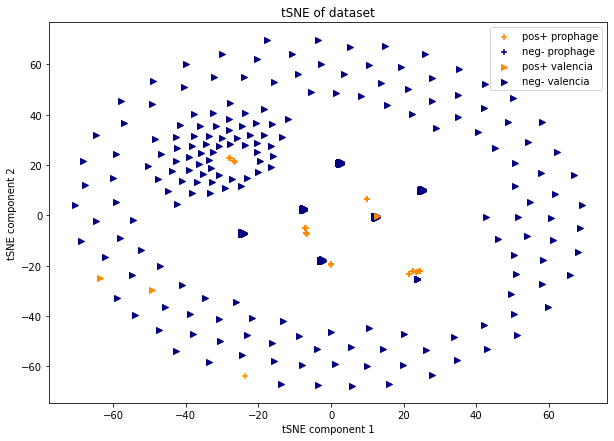

In [34]:
# colored by label
X_tsne = TSNE(n_components=2, learning_rate='auto', init='random').fit_transform(X_rbps)
plt.figure(figsize=(10,7))
colors = ["navy", "darkorange"]

for i in range(X_tsne.shape[0]):
    if (frame['origin'][i] == 'prophage') and (labels[i] == 1):
        plt.scatter(X_tsne[i,0], X_tsne[i,1], color='darkorange', marker='+')
    if (frame['origin'][i] == 'prophage') and (labels[i] == 0):
        plt.scatter(X_tsne[i,0], X_tsne[i,1], color='navy', marker='+')
    if (frame['origin'][i] == 'valencia') and (labels[i] == 1):
        plt.scatter(X_tsne[i,0], X_tsne[i,1], color='darkorange', marker='>')
    if (frame['origin'][i] == 'valencia') and (labels[i] == 0):
        plt.scatter(X_tsne[i,0], X_tsne[i,1], color='navy', marker='>')
        
plt.scatter([],[], color='darkorange', marker='+', label='pos+ prophage')
plt.scatter([],[], color='navy', marker='+', label='neg- prophage')
plt.scatter([],[], color='darkorange', marker='>', label='pos+ valencia')
plt.scatter([],[], color='navy', marker='>', label='neg- valencia')
  
plt.legend(loc="best", shadow=False, scatterpoints=1)
plt.title("tSNE of dataset")
plt.xlabel('tSNE component 1')
plt.ylabel('tSNE component 2')
#plt.savefig(results_dir+'/features/all_embeddings_tSNE.png', dpi=400)

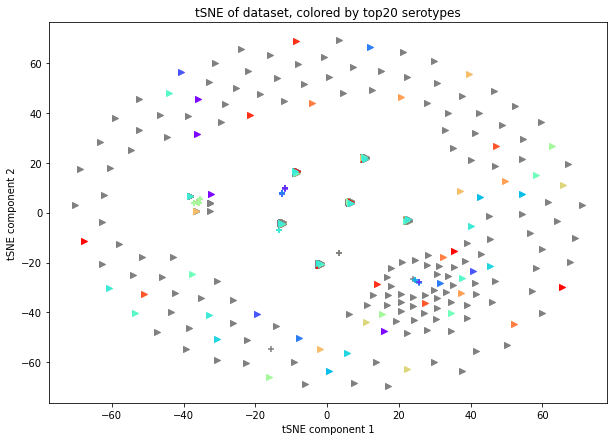

In [36]:
# colored by serotype
X_tsne = TSNE(n_components=2, learning_rate='auto', init='random').fit_transform(X_rbps)
seros = pd.read_csv(klebsiella_dir+'/klebsiella_genomes_031221_serotypes.csv')
unique_seros = list(set(seros['sero']))
seros_count = [list(seros['sero']).count(x) for x in unique_seros]
seros_top = [x for _,x in sorted(zip(seros_count,unique_seros), reverse=True)][:20]
plt.figure(figsize=(10,7))
viridis = cm.get_cmap('rainbow')
crange = np.linspace(0.01, 0.99, len(seros_top))

for i in range(X_tsne.shape[0]):
    this_index = frame['row'][i]
    this_sero = seros['sero'][this_index]
    if (frame['origin'][i] == 'prophage') and (this_sero in seros_top):
        col = viridis(crange[seros_top.index(this_sero)])
        plt.scatter(X_tsne[i,0], X_tsne[i,1], color=col, marker='+')
    if (frame['origin'][i] == 'prophage') and (this_sero not in seros_top):
        plt.scatter(X_tsne[i,0], X_tsne[i,1], color='grey', marker='+')
    if (frame['origin'][i] == 'valencia') and (this_sero in seros_top):
        col = viridis(crange[seros_top.index(this_sero)])
        plt.scatter(X_tsne[i,0], X_tsne[i,1], color=col, marker='>')
    if (frame['origin'][i] == 'valencia') and (this_sero not in seros_top):
        plt.scatter(X_tsne[i,0], X_tsne[i,1], color='grey', marker='>')
         
plt.title("tSNE of dataset, colored by top20 serotypes")
plt.xlabel('tSNE component 1')
plt.ylabel('tSNE component 2')
plt.savefig(results_dir+'/features/rbp_embeddings_tSNE_serocolor.png', dpi=400)

Text(0, 0.5, 'tSNE component 2')

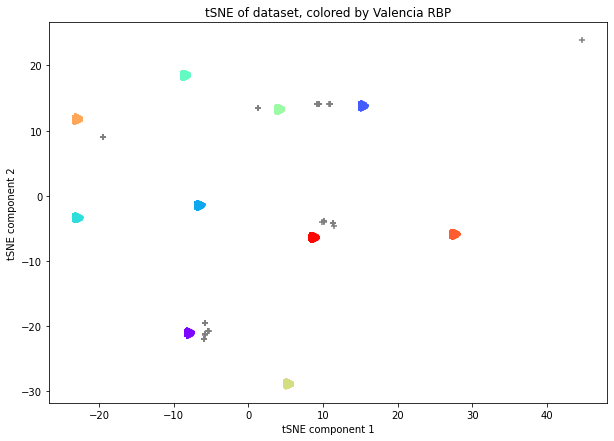

In [82]:
# colored with Valencia RBPs
X_tsne = TSNE(n_components=2, perplexity=61, learning_rate='auto', init='random').fit_transform(X_rbps)

unique_valencia_rbps = list(set(frame['col'][frame['origin']=='valencia']))
colors = cm.get_cmap('rainbow')
crange = np.linspace(0.01, 0.99, len(unique_valencia_rbps))

plt.figure(figsize=(10,7))
for i in range(X_tsne.shape[0]):
    this_rbp = frame['col'][i]
    if (frame['origin'][i] == 'prophage'):        
        plt.scatter(X_tsne[i,0], X_tsne[i,1], color='grey', marker='+')
    if (frame['origin'][i] == 'valencia'):
        col = colors(crange[unique_valencia_rbps.index(this_rbp)])
        plt.scatter(X_tsne[i,0], X_tsne[i,1], color=col, marker='>')
         
plt.title("tSNE of dataset, colored by Valencia RBP")
plt.xlabel('tSNE component 1')
plt.ylabel('tSNE component 2')
#plt.savefig(results_dir+'/features/rbp_embeddings_tSNE_serocolor.png', dpi=400)

In [60]:
# are the different embeddings the same?
frame_rbps = frame.iloc[:, 1024:-4]
unique_valencia_rbps = list(set(frame['col'][frame['origin']=='valencia']))
frame_rbps[frame['col'] == 1538]

,0,1,2,3,4,5,6,7,8,9,...,1014,1015,1016,1017,1018,1019,1020,1021,1022,1023
132,0.019961,-0.009518,0.001155,0.012606,0.068221,-0.022728,0.001187,-0.004848,-0.084081,0.026543,...,-0.010422,-0.044509,-0.023501,-0.033047,0.093405,0.024353,-0.005163,0.005833,-0.002526,0.033885
142,0.019961,-0.009518,0.001155,0.012606,0.068221,-0.022728,0.001187,-0.004848,-0.084081,0.026543,...,-0.010422,-0.044509,-0.023501,-0.033047,0.093405,0.024353,-0.005163,0.005833,-0.002526,0.033885
152,0.019961,-0.009518,0.001155,0.012606,0.068221,-0.022728,0.001187,-0.004848,-0.084081,0.026543,...,-0.010422,-0.044509,-0.023501,-0.033047,0.093405,0.024353,-0.005163,0.005833,-0.002526,0.033885
162,0.019961,-0.009518,0.001155,0.012606,0.068221,-0.022728,0.001187,-0.004848,-0.084081,0.026543,...,-0.010422,-0.044509,-0.023501,-0.033047,0.093405,0.024353,-0.005163,0.005833,-0.002526,0.033885
172,0.019961,-0.009518,0.001155,0.012606,0.068221,-0.022728,0.001187,-0.004848,-0.084081,0.026543,...,-0.010422,-0.044509,-0.023501,-0.033047,0.093405,0.024353,-0.005163,0.005833,-0.002526,0.033885
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
702,0.019961,-0.009518,0.001155,0.012606,0.068221,-0.022728,0.001187,-0.004848,-0.084081,0.026543,...,-0.010422,-0.044509,-0.023501,-0.033047,0.093405,0.024353,-0.005163,0.005833,-0.002526,0.033885
712,0.019961,-0.009518,0.001155,0.012606,0.068221,-0.022728,0.001187,-0.004848,-0.084081,0.026543,...,-0.010422,-0.044509,-0.023501,-0.033047,0.093405,0.024353,-0.005163,0.005833,-0.002526,0.033885
722,0.019961,-0.009518,0.001155,0.012606,0.068221,-0.022728,0.001187,-0.004848,-0.084081,0.026543,...,-0.010422,-0.044509,-0.023501,-0.033047,0.093405,0.024353,-0.005163,0.005833,-0.002526,0.033885
732,0.019961,-0.009518,0.001155,0.012606,0.068221,-0.022728,0.001187,-0.004848,-0.084081,0.026543,...,-0.010422,-0.044509,-0.023501,-0.033047,0.093405,0.024353,-0.005163,0.005833,-0.002526,0.033885


We see that the prophage datapoints (if plotted), are quite different from the Valencia data. Within the Valencia data however we see different clusters of points, but the positives are not separatable from the negatives (in two dimensions).

Qs: What do the clusters represent? What does this mean? That the difference between pos/neg is smaller/more subtle than another difference between the datapoints?

Coloring the datapoints by serotype (top20) does not reveal that the different clusters are linked to different serotypes, so there's something else behind it...

A t-SNE of the loci_embeddings turns out quite nicely, we clearly see separations between the different serotypes. The rbp_embeddings turn out weird... these should be doublechecked.

Text(0, 0.5, 'UMAP component 2')

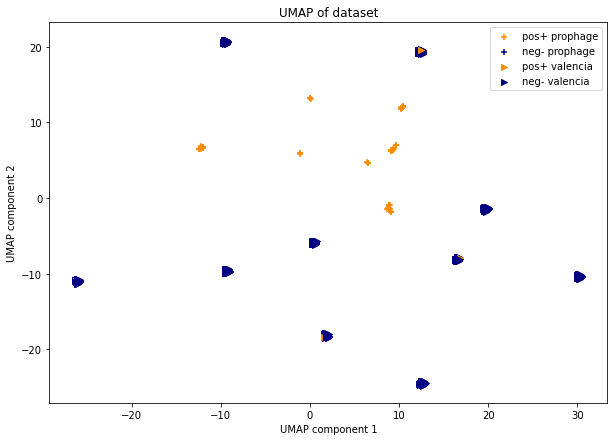

In [21]:
# colored by label
reducer = umap.UMAP()
X_umap = reducer.fit_transform(X_rbps)

plt.figure(figsize=(10,7))
colors = ["navy", "darkorange"]

for i in range(X_umap.shape[0]):
    if (frame['origin'][i] == 'prophage') and (labels[i] == 1):
        plt.scatter(X_umap[i,0], X_umap[i,1], color='darkorange', marker='+')
    if (frame['origin'][i] == 'prophage') and (labels[i] == 0):
        plt.scatter(X_umap[i,0], X_umap[i,1], color='navy', marker='+')
    if (frame['origin'][i] == 'valencia') and (labels[i] == 1):
        plt.scatter(X_umap[i,0], X_umap[i,1], color='darkorange', marker='>')
    if (frame['origin'][i] == 'valencia') and (labels[i] == 0):
        plt.scatter(X_umap[i,0], X_umap[i,1], color='navy', marker='>')
        
plt.scatter([],[], color='darkorange', marker='+', label='pos+ prophage')
plt.scatter([],[], color='navy', marker='+', label='neg- prophage')
plt.scatter([],[], color='darkorange', marker='>', label='pos+ valencia')
plt.scatter([],[], color='navy', marker='>', label='neg- valencia')
  
plt.legend(loc="best", shadow=False, scatterpoints=1)
plt.title("UMAP of dataset")
plt.xlabel('UMAP component 1')
plt.ylabel('UMAP component 2')
#plt.savefig(results_dir+'/features/all_embeddings_UMAP.png', dpi=400)

Text(0, 0.5, 'UMAP component 2')

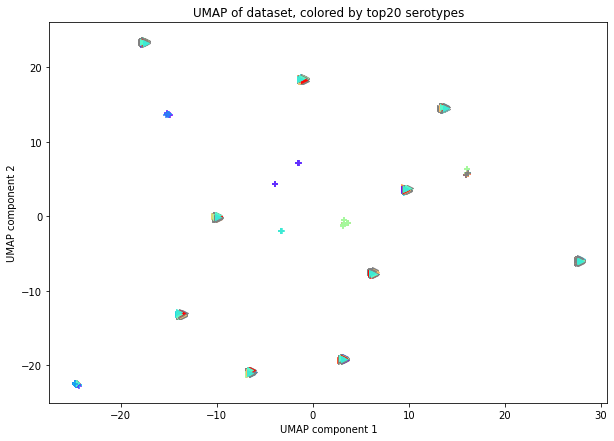

In [53]:
# colored by serotype
reducer = umap.UMAP()
X_umap = reducer.fit_transform(X_rbps)
seros = pd.read_csv(klebsiella_dir+'/klebsiella_genomes_031221_serotypes.csv')
unique_seros = list(set(seros['sero']))
seros_count = [list(seros['sero']).count(x) for x in unique_seros]
seros_top = [x for _,x in sorted(zip(seros_count,unique_seros), reverse=True)][:20]
plt.figure(figsize=(10,7))
rainbow = cm.get_cmap('rainbow')
crange = np.linspace(0.01, 0.99, len(seros_top))

for i in range(X_umap.shape[0]):
    this_index = frame['row'][i]
    this_sero = seros['sero'][this_index]
    if (frame['origin'][i] == 'prophage') and (this_sero in seros_top):
        col = rainbow(crange[seros_top.index(this_sero)])
        plt.scatter(X_umap[i,0], X_umap[i,1], color=col, marker='+')
    elif (frame['origin'][i] == 'prophage') and (this_sero not in seros_top):
        plt.scatter(X_umap[i,0], X_umap[i,1], color='grey', marker='+')
    elif (frame['origin'][i] == 'valencia') and (this_sero in seros_top):
        col = rainbow(crange[seros_top.index(this_sero)])
        plt.scatter(X_umap[i,0], X_umap[i,1], color=col, marker='>')
    elif (frame['origin'][i] == 'valencia') and (this_sero not in seros_top):
        plt.scatter(X_umap[i,0], X_umap[i,1], color='grey', marker='>')
        
#plt.scatter([],[], color='darkorange', marker='+', label='pos+ prophage')
#plt.scatter([],[], color='navy', marker='+', label='neg- prophage')
#plt.scatter([],[], color='darkorange', marker='>', label='pos+ valencia')
#plt.scatter([],[], color='navy', marker='>', label='neg- valencia')
  
#plt.legend(loc="best", shadow=False, scatterpoints=1)
plt.title("UMAP of dataset, colored by top20 serotypes")
plt.xlabel('UMAP component 1')
plt.ylabel('UMAP component 2')
#plt.savefig(results_dir+'/features/all_embeddings_UMAP_serocolor.png', dpi=400)

In [ ]:
# look at rbps that have UMAP C1 > 25 (every UMAP will look slightly different, look at the plot above!)
count = 0
for i in range(X_umap.shape[0]):
    if X_umap[i,0] > 25:
        phage_number = frame['col'][i]
        #print(phage_number)
        count += 1
count

Looking at the UMAP projections of RBP embeddings, we see sort of the same pattern as we are witnessing in the full embeddings projections. This indicates that that 'weird' pattern is in fact the result of the RBP embeddings. A CD-HIT clusters analysis of the Valencia RBPs does not reveal anything suspicious in particular. Meaning that the sequences do in fact look  normal, some more similar then others.

Results: every cluster is in fact a single RBP. Most of these datapoints are negative, and then one or a few are positive. This makes sense in the Valencie database, as every phage was tested against a panel of bacterial strains. And because we only have a few RBPs still in our dataset (cfr ongoing structure prediction efforts), we see a finite number of different clusters, all relating to a particular RBP! Though the tSNE of RBPs is still a weird pattern that has no explanation...

After looking at the tSNE in more detail, colored by Valencia RBPs (see above), we see that the same RBPs are actually plotted at different points on the tSNE! This is weird, but it's even weirder because not all of them do this, some are actually plotted on top of one another just like the UMAP. Two RBPs in particular make up the weird circle like pattern. Must check these in a bit more detail. OK so the RBPs themselves (and their embeddings), don't look weird. I've looked up some more info on tSNE and found the perplexity parameter (i.e. number of effective neighbors in learning the manifold) and it's default is 30. Lower values look even worse, but higher values look good (>61). So the weird results might be simply the result of a parameter that wasn't properly set. As a sanity check, let's do a simple PCA and see what that gives.

Text(0, 0.5, 'tSNE component 2')

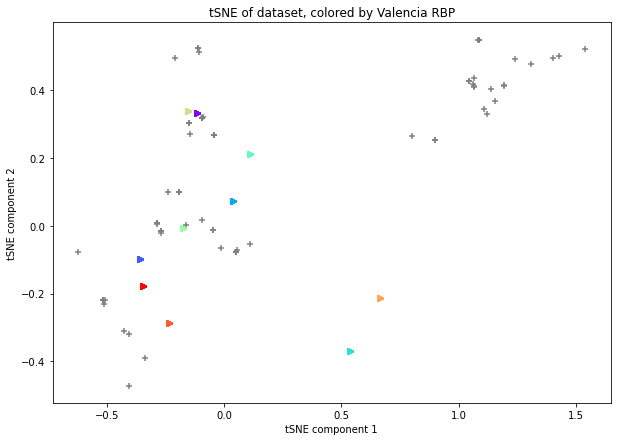

In [84]:
# colored with Valencia RBPs
X_PCA = PCA(n_components=2).fit_transform(X_rbps)

unique_valencia_rbps = list(set(frame['col'][frame['origin']=='valencia']))
colors = cm.get_cmap('rainbow')
crange = np.linspace(0.01, 0.99, len(unique_valencia_rbps))

plt.figure(figsize=(10,7))
for i in range(X_tsne.shape[0]):
    this_rbp = frame['col'][i]
    if (frame['origin'][i] == 'prophage'):        
        plt.scatter(X_PCA[i,0], X_PCA[i,1], color='grey', marker='+')
    if (frame['origin'][i] == 'valencia'):
        col = colors(crange[unique_valencia_rbps.index(this_rbp)])
        plt.scatter(X_PCA[i,0], X_PCA[i,1], color=col, marker='>')
         
plt.title("tSNE of dataset, colored by Valencia RBP")
plt.xlabel('tSNE component 1')
plt.ylabel('tSNE component 2')
#plt.savefig(results_dir+'/features/rbp_embeddings_tSNE_serocolor.png', dpi=400)

In [ ]:
valencia_dir = '/Users/dimi/GoogleDrive/PhD/4_PHAGEHOST_LEARNING/42_DATA/Valencia_data'
RBPbaseValencia = pd.read_csv(valencia_dir+'/RBPbaseValencia.csv')

fasta = open(valencia_dir+'/RBPs_valencia.fasta', 'w')
for i, sequence in enumerate(RBPbaseValencia['protein_seq']):
    identifier = RBPbaseValencia['unique_ID'][i]
    fasta.write('>'+identifier+'\n'+sequence+'\n')
fasta.close()
    
cdpath = '/Users/dimi/cd-hit-v4.8.1-2019-0228'
input_file = valencia_dir+'/RBPs_valencia.fasta'
output_file = valencia_dir+'/RBP_clusters_valencia'
cdout, cderr = exu.cdhit_python(cdpath, input_file, output_file)

## 6 - Machine learning models <a name="models"></a>

##### Binary classification

In [83]:
# first simple test
rf = RandomForestClassifier(n_estimators=500, class_weight='balanced')
outer_cv = StratifiedKFold(n_splits=4)
score_f1 = make_scorer(f1_score, average='weighted')
frame = np.asarray(frame.iloc[:,:-1])
perf_f1 = cross_val_score(rf, X=frame[:,:-1], y=frame[:,-1], scoring=score_f1, cv=outer_cv, verbose=False)
np.mean(perf_f1)

In [111]:
# grouped K-fold taking into account the loci
loci_sim = np.loadtxt(klebsiella_dir+'/kaptive_loci_score_matrix.txt')
rf = RandomForestClassifier(n_estimators=200, class_weight='balanced')
loci_cv = KFold(n_splits=5, shuffle=True)
frame_array = np.asarray(frame.iloc[:,:-2])
labels = np.asarray(frame.iloc[:,-2])
fscores = []
for train_index, test_index in loci_cv.split(loci_sim):
    # construct training and test dataframe
    train_index_frame = []; test_index_frame = []
    for i, row_id in enumerate(frame['row']):
        if row_id in train_index:
            train_index_frame.append(i)
        else:
            test_index_frame.append(i)
    frame_train, frame_test = frame_array[train_index_frame], frame_array[test_index_frame]
    labels_train, labels_test = labels[train_index_frame], labels[test_index_frame]
    
    # fit a model
    rf.fit(frame_train, labels_train)
    
    # make predictions and test
    preds = rf.predict(frame_test)
    fscores.append(f1_score(labels_test, preds))
print(fscores, 'mean: ', np.mean(fscores))

In [81]:
# grouped loci K-fold with ranking accuracy
"""
downside is that we make a lot of predictions for out-of-data samples, that we don't know are good or bad...

IDEA: only loop over RBPs for which interactions are known, not all RBPs. Then rank those and see if at least one
positive is in the top 10. That's the primary metric we are looking at: does a working RBP come out on top? 
Would that work?
"""
dim_features_loci = 1024
loci_sim = np.loadtxt(klebsiella_dir+'/kaptive_loci_score_matrix.txt')
rf = RandomForestClassifier(n_estimators=200, class_weight='balanced', n_jobs=6)
loci_cv = KFold(n_splits=5, shuffle=True)
frame_array = np.asarray(frame.iloc[:,:-2])
labels = np.asarray(frame.iloc[:,-2])
top10acc = []
for train_index, test_index in loci_cv.split(loci_sim):
    print('new split')
    # construct training and test dataframe
    train_index_frame = []; test_index_frame = []
    for i, row_id in enumerate(frame['row']):
        if row_id in train_index:
            train_index_frame.append(i)
        else:
            test_index_frame.append(i)
    frame_train, frame_test = frame_array[train_index_frame], frame_array[test_index_frame]
    labels_train, labels_test = labels[train_index_frame], labels[test_index_frame]
    
    # fit a model
    rf.fit(frame_train, labels_train)
    
    # make predictions and test
    test_row_ids = list(set(frame['row'][test_index_frame]))
    pos_sum = 0 # track all positives per cv split to compute accuracy
    correct_preds_sum = 0
    for test_row_index in tqdm(test_row_ids): # loop over test loci
        probs = []
        test_locus_embedding = np.asarray(locus_em.iloc[test_row_index,:]) # locus feats
        positives = [i for i, label in enumerate(labels) if (label == 1) and (frame['row'][i] == test_row_index)]
        pos_sum += len(positives)
        
        # loop over all RBPs
        for rbp_row in range(frame_array.shape[0]):
            test_rbp_embedding = frame_array[rbp_row, dim_features_loci:] # RBP feats
            test_embedding = np.concatenate([test_locus_embedding, test_rbp_embedding]).reshape(1,-1)
            probs.append(rf.predict_proba(test_embedding)[:,1])
        
        # sort probs and get top10 indices
        top10_RBPs = [x for _, x in sorted(zip(probs, range(frame_array.shape[0])), reverse=True)][:10]
        top10_probs = sorted(probs, reverse=True)
        correct_predicted_positives = list(set(top10_RBPs).intersection(positives))
        correct_preds_sum += len(correct_predicted_positives)
    
    # compute top10 accuracy
    top10acc.append(correct_preds_sum/pos_sum)
        
print(top10acc, 'mean: ', np.mean(top10acc))

new split


100%|███████████████████████████████████████████| 37/37 [06:05<00:00,  9.89s/it]


new split


100%|███████████████████████████████████████████| 42/42 [07:02<00:00, 10.06s/it]


new split


100%|███████████████████████████████████████████| 38/38 [06:19<00:00,  9.99s/it]


new split


100%|███████████████████████████████████████████| 40/40 [06:37<00:00,  9.93s/it]


new split


100%|███████████████████████████████████████████| 35/35 [05:48<00:00,  9.95s/it]

[0.025, 0.0, 0.07352941176470588, 0.03333333333333333, 0.04878048780487805] mean:  0.03612864658058346


In [119]:
# RANDOM SHUFFLE LABELS
loci_sim = np.loadtxt(klebsiella_dir+'/kaptive_loci_score_matrix.txt')
rf = RandomForestClassifier(n_estimators=200, class_weight='balanced')
loci_cv = KFold(n_splits=5, shuffle=True)
frame_array = np.asarray(frame.iloc[:,:-2])
labels = np.asarray(frame.iloc[:,-2])
random.shuffle(labels)
fscores = []
for train_index, test_index in loci_cv.split(loci_sim):
    # construct training and test dataframe
    train_index_frame = []; test_index_frame = []
    for i, row_id in enumerate(frame['row']):
        if row_id in train_index:
            train_index_frame.append(i)
        else:
            test_index_frame.append(i)
    frame_train, frame_test = frame_array[train_index_frame], frame_array[test_index_frame]
    labels_train, labels_test = labels[train_index_frame], labels[test_index_frame]
    
    # fit a model
    rf.fit(frame_train, labels_train)
    
    # make predictions and test
    preds = rf.predict(frame_test)
    fscores.append(f1_score(labels_test, preds))
print(fscores, 'mean: ', np.mean(fscores))

[0.038461538461538464, 0.0, 0.08, 0.04597701149425287, 0.03636363636363636] mean:  0.04016043726388554


##### Structured-output learning

In [37]:
rbpbase = pd.read_csv(data_dir+'/RBPbase_250621_klebsiella_pneumoniae.csv')
locus_em = pd.read_csv(data_dir+'/locus_embeddings.csv', index_col=0)
rbp_em = pd.read_csv(data_dir+'/protein_embeddings.csv', index_col=0)

In [12]:
# k-nearest neighbors for multioutput regression
from sklearn.datasets import make_regression
from sklearn.neighbors import KNeighborsRegressor
import numpy as np
# create datasets
X, y = make_regression(n_samples=1000, n_features=10, n_informative=5, n_targets=5, random_state=1, noise=0.5)
# define model
model = KNeighborsRegressor()
# fit model
model.fit(X, y)
# make a prediction
row = [0.21947749, 0.32948997, 0.81560036, 0.440956, -0.0606303, -0.29257894, -0.2820059, -0.00290545, 0.96402263, 0.04992249]
yhat = model.predict([row])
# summarize prediction
print(yhat[0])

[121.73740733  31.15853281  98.09647206  67.71553523  41.61800365]


In [106]:
# construct simple X and Y off of the embeddings
X = np.zeros((rbpbase.shape[0], locus_em.shape[1]))
host_names = list(locus_em.index)
for row, host in enumerate(rbpbase['host_accession']):
    index = [i for i, x in enumerate(host_names) if host in x][0]
    X[row, :] = locus_em.iloc[index, :]
    
from sklearn.decomposition import PCA
pca = PCA(n_components=5)
Y = pca.fit_transform(rbp_em)

In [107]:
# fit a linear model without jointXY
W1 = np.linalg.inv(np.dot(X.T, X))
W2 = np.dot(X.T, Y)
W = np.dot(W1, W2)

In [110]:
# make predictions & compute naive accuracy
acc = 0
for row in range(X.shape[0]):
    yhat = np.dot(W.T, X[row,:])
    distances = [sum(abs(Y[i,:]-yhat)) for i in range(Y.shape[0])]
    #prediction = distances.index(min(distances))
    preds = np.argsort(distances)[:20]
    if row in preds:
        acc += 1
print('accuracy: ', acc/X.shape[0])

accuracy:  0.0332667997338656


In [ ]:
from sklearn.neighbors import KNeighborsRegressor
model = KNeighborsRegressor()
model.fit(X, Y)

# make predictions & compute naive accuracy
acc = 0
for row in range(X.shape[0]):
    yhat = model.predict([X[row,:]])
    distances = [sum(abs(Y[i,:]-yhat)) for i in range(Y.shape[0])]
    preds = np.argsort(distances)[:10]
    if row in preds:
        acc += 1
print('accuracy: ', acc/X.shape[0])

In [22]:
jointXY = ...

# fit on the data
W1 = np.linalg.inv(np.dot(jointXY.T, jointXY))
W2 = np.dot(jointXY.T, y)
W = np.dot(W1, W2)

# make preds for new data: for every X in the testset, we construct a jointXY_test
for row in range(Y.shape[1]):
    Yi = Y[row, :]
    

(1000, 5)

## X - Out of use